In [8]:
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import sys


3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]


In [2]:
"""
general outline

each pixel: r, g, b, 8 for prediction, 10 for information flow (21)
input: 9 x pixel, 3x3 convoltuion which is the flattened (189)
1 dense layer: 256 relu
output: 8 sigmoid
loss: cross entrpoy


"""

'\ngeneral outline\n\neach pixel: r, g, b, 8 for prediction, 10 for information flow (21)\ninput: 9 x pixel, 3x3 convoltuion which is the flattened\n\n\n'

In [4]:
def perceive(state):
    sobel_y = np.array([[1,2,1],
                        [0,0,0],
                        [-1, -2, -1]])
    sobel_x = sobel_y.T
    
    grad_x = cv2.filter2D(state, -1, sobel_x)
    grad_y = cv2.filter2D(state, -1, sobel_y)
    print(state.shape, grad_x.shape, grad_y.shape)
    return np.stack([state, grad_x, grad_y])

In [94]:
def mask_to_label(mask):
    colors = [(0,0,0), (0,0,1), (0,1,0), (0,1,1), 
             (1,0,0), (1,0,1), (1,1,0), (1,1,1)]
    color_to_index = dict(zip(colors, range(len(colors))))
    pix_to_index = lambda pixel: color_to_index.get(tuple([p.item() for p in pixel]))
    label_mask = t.zeros(len(colors), mask.shape[1], mask.shape[2])
    for i in range(mask.shape[1]):
        for j in range(mask.shape[2]):
            index = pix_to_index(mask[:,i,j])
            if index == None:
                print(mask[:,i,j])
            label_mask[index, i, j] = 1
    return label_mask
            

In [127]:
class OceanDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, 'images')
        self.msk_dir = os.path.join(root_dir, 'masks')
        self.names = np.array([s.split('.')[0] for s in os.listdir(self.img_dir)])
        self.transform = transform
        
        
    def __len__(self):
        return len(os.listdir(self.img_dir))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.names[idx] + '.jpg')
        msk_path = os.path.join(self.msk_dir, self.names[idx] + '.bmp')
        img, msk = cv2.imread(img_path), cv2.imread(msk_path)
        
        #there is no image normalization thus far
        #I'm going to see how it works then come back
        
        #maybe I should be converting the mask into a w x h x label
        if self.transform: 
            img = cv2.cvtColor(cv2.resize(img, (256, 256)), cv2.COLOR_BGR2RGB)
            msk = cv2.cvtColor(cv2.resize(msk, (256, 256), interpolation=0), cv2.COLOR_BGR2RGB)
            img = self.transform(img)
            msk = self.transform(msk)
            msk = msk.round()
        return img, msk, mask_to_label(msk)
        

In [128]:
root_dir = 'data/SUIM/train'
trans = transforms.Compose([
    transforms.ToTensor()
])

od = OceanDataset(root_dir, transform=trans)

In [76]:
img, msk, msk_lb = od[0]

In [73]:
msk.shape

torch.Size([3, 256, 256])

In [67]:
test_loader = DataLoader(od, batch_size=32, shuffle=True)

In [69]:
img, msk, msk_lb = next(iter(test_loader))

IndexError: index 33 is out of bounds for dimension 1 with size 8

In [111]:
model = nn.Sequential(
    nn.Linear(9*21, 256),
    nn.ReLU(),
    nn.Linear(256, 8),
    nn.Sigmoid()
)
loss = nn.CrossEntropyLoss()
# optim = optim.Adam(model.parameters(), lr=0.001)

sobel_y = np.array([[1,2,1],
         [0,0,0],
         [-1, -2, -1]])
sobel_x = sobel_y.T
test_img = cv2.imread('data/SUIM/train/images/d_r_18_.jpg')
test_msk = cv2.imread('data/SUIM/train/masks/w_r_136_.bmp')

In [109]:
od.names[10]

'w_r_136_'

In [ ]:
os.makedirs('data/SUIM/train/images_trans', exist_ok=True)
os.makedirs('data/SUIM/train/masks_pred', exist_ok=True)
for i, name in enumerate(od.names):
    if i % 100 == 0:
        print(i)
    img, msk, msk_lb = od[i]
    t.save(img, 'data/SUIM/train/images_trans/' + name + '.pt')
    t.save(msk_lb, 'data/SUIM/train/masks_pred/' + name + '.pt')
    
    
    

0
100
200


In [98]:
i

10

In [101]:
img, msk = od[10]

In [105]:
msk.round()

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


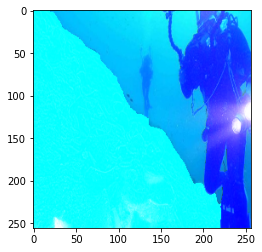

In [118]:
plt.imshow(img.permute(1,2,0)+msk.permute(1,2,0).round())

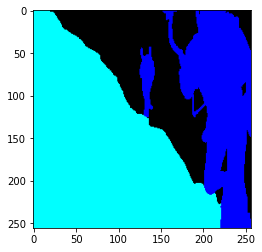

In [116]:
plt.imshow(msk.permute(1,2,0).round())

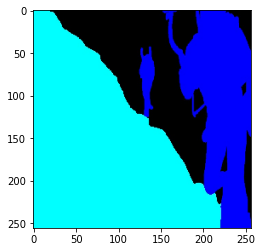

In [108]:
plt.imshow(msk.permute(1,2,0))

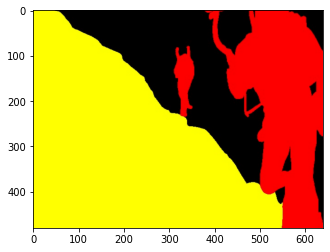

In [113]:
plt.imshow(test_msk)